In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow_datasets as tfds
from tensorflow.data.experimental import sample_from_datasets

tfkl = tfk.layers

**Preprocessing**

As typical, we'll start with the MNIST data. Recall from last time, we have to do some transformations and preprocessing on these images.

In [2]:
data, info = tfds.load('mnist', with_info=True)

In [3]:
preprocess = lambda d: (tf.cast(d["image"], tf.float32)/255, tf.one_hot(d["label"], depth=10))

ds_train = data["train"].map(preprocess).cache().batch(32)
ds_test = data["test"].map(preprocess).cache().batch(32)

In [4]:
img_shape = info.features['image'].shape

In [5]:
img_shape

(28, 28, 1)

In [10]:
x,y = next(iter(ds_train))

In [18]:
x.shape

TensorShape([32, 28, 28, 1])

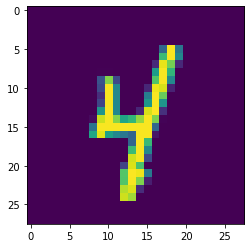

In [17]:
x,y = next(iter(ds_train))
plt.imshow(x[0,:,:,0])

**CNNs in TF Keras**

We'll use the Sequential class rely on new layer types that correspond to concepts we covered in lecture: Conv2D, AvgPool2D, MaxPool2D. 

Details such as kernel size, padding, strides and so on must be specified as args to these classes, where appropriate.

In [21]:
model = tfk.Sequential()
model.add(tfkl.Conv2D(filters = 1, kernel_size=(3,3), strides=(1,1), 
                      padding="valid", activation='relu', input_shape=(28, 28, 1))) #smooth stride; padding: handle edges;
model.add(tfkl.MaxPool2D(pool_size=(4,4)))
#tfkl.GlobalMaxPool2D() works like Flatten(), find the biggest number in 32 batches and gives you the size of (6,6,1)
model.add(tfkl.Flatten())
model.add(tfkl.Dense(10, activation='softmax'))
#output layer is with 10 units for 10 digits

In [22]:
model.summary() 

#(None,26,26,1)->(batch size left unspecified but actually 32, image size)
# why is 10 parameters? treat every kernal as a neuron, there should be 9 parameters + 1 bias


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 1)         10        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 1)           0         
_________________________________________________________________
flatten (Flatten)            (None, 36)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                370       
Total params: 380
Trainable params: 380
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.compile(
    optimizer=tfk.optimizers.RMSprop(),
    loss=tfk.losses.CategoricalCrossentropy(),
)

results = model.fit(ds_train, steps_per_epoch=20, epochs=20, validation_data=ds_test)

Epoch 1/20
20/20 [==============================] - 1s 62ms/step - loss: 2.3935 - val_loss: 2.3238
Epoch 2/20
20/20 [==============================] - 1s 28ms/step - loss: 2.2716 - val_loss: 2.2583
Epoch 3/20
20/20 [==============================] - 1s 28ms/step - loss: 2.2519 - val_loss: 2.2103
Epoch 4/20
20/20 [==============================] - 1s 29ms/step - loss: 2.1872 - val_loss: 2.1649
Epoch 5/20
20/20 [==============================] - 1s 28ms/step - loss: 2.1672 - val_loss: 2.1169
Epoch 6/20
20/20 [==============================] - 1s 28ms/step - loss: 2.0949 - val_loss: 2.0611
Epoch 7/20
20/20 [==============================] - 1s 29ms/step - loss: 2.0537 - val_loss: 1.9999
Epoch 8/20
20/20 [==============================] - 1s 28ms/step - loss: 1.9680 - val_loss: 1.9355
Epoch 9/20
20/20 [==============================] - 1s 28ms/step - loss: 1.8839 - val_loss: 1.8634
Epoch 10/20
20/20 [==============================] - 1s 29ms/step - loss: 1.8662 - val_loss: 1.7890
Epoch 11/

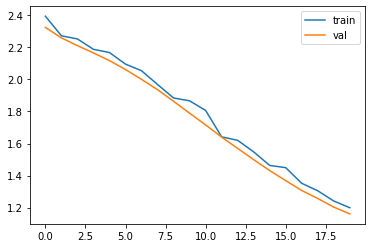

In [24]:
plt.plot(results.history["loss"])
plt.plot(results.history["val_loss"])
plt.legend(labels=["train", "val"])

In [55]:
model.predict(ds_test.take(1)).shape 
#32 batches(images),probabilities for 10 digits

(32, 10)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'Probability')

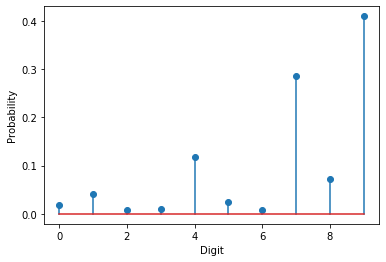

In [64]:
plt.stem(model.predict(ds_test.take(1))[13, :]) 
#look at the confidence when you change to other specific digits
#e.g the 9th sample has high prob of being 1, 10th for 8 and 5, 11th for 0
plt.xlabel("Digit")
plt.ylabel("Probability")

In [35]:
x,y = next(iter(ds_test))

In [56]:
x.shape

TensorShape([32, 28, 28, 1])

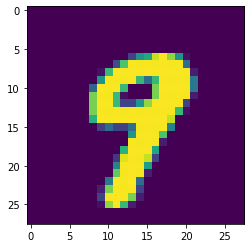

In [65]:
plt.imshow(x[13,:,:,0])

In [ ]:
#about batch
x,y = next(iter(ds_train.unbatch().batch(64)))

Which architectural hyperparameters might we change in the above?



**Exercise - Deep CNN**

Build and fit your own CNN model with 3 convolutional **modules**, where each one contains:
  * kernel convolution 
    * you pick number of kernels
    * you pick kernel shape/size
    * you pick activation
  * pooling
  * dropout

We'll use the Fashion MNIST dataset, a low-res collection of images of clothing.

In [135]:
train, test = tf.keras.datasets.fashion_mnist.load_data()

images, labels = train
images = images/255.0
images = images[:, :, :, np.newaxis]
labels = tf.one_hot(labels.astype(np.int32),depth=10) 
#!! CONVERT label output(0-9) to one-hot vector of length 10; or else shape won't match with output layer with 10 units

# optional - TF Datasets objects
# fmnist_train_ds = tf.data.Dataset.from_tensor_slices((images, labels))
# fmnist_train_ds = fmnist_train_ds.shuffle(5000).batch(32)


In [137]:
images.shape

(60000, 28, 28, 1)

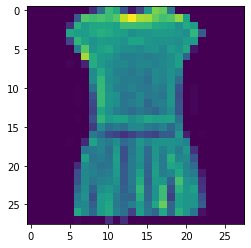

In [67]:
plt.imshow(images[3, :, :, 0].squeeze())

In [75]:
model = tfk.Sequential()

#Block 1
model.add(tfkl.Conv2D(filters = 20, kernel_size=(3,3), strides=(3,3), 
                      padding="valid", activation='relu', input_shape=(28, 28, 1))) #smooth stride; padding: handle edges;
model.add(tfkl.MaxPool2D(pool_size=2))
model.add(tfkl.Dropout(.2))

#Block 2
model.add(tfkl.Conv2D(filters = 16, kernel_size=2, strides=2, 
                      padding="valid", activation='relu')) #smooth stride; padding: handle edges;
model.add(tfkl.MaxPool2D(pool_size=2))
model.add(tfkl.Dropout(.2))

#Block 3
model.add(tfkl.Conv2D(filters = 8, kernel_size=2, strides=2, 
                      padding="valid", activation='relu')) #smooth stride; padding: handle edges;
model.add(tfkl.MaxPool2D(pool_size=2))
model.add(tfkl.Dropout(.2))

#Flatten
model.add(tfkl.GlobalMaxPool2D())
model.add(tfkl.Dense(10, activation='softmax'))

In [76]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 9, 9, 20)          200       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 20)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                3210      
Total params: 3,410
Trainable params: 3,410
Non-trainable params: 0
_________________________________________________________________


In [104]:
model.compile(
    optimizer=tfk.optimizers.RMSprop(),
    loss=tfk.losses.CategoricalCrossentropy(),
)

results = model.fit(images, labels, batch_size=32, steps_per_epoch=20, epochs=20)

Epoch 1/20
20/20 [==============================] - 0s 2ms/step - loss: 2.2412
Epoch 2/20
20/20 [==============================] - 0s 2ms/step - loss: 2.0568
Epoch 3/20
20/20 [==============================] - 0s 2ms/step - loss: 1.8443
Epoch 4/20
20/20 [==============================] - 0s 2ms/step - loss: 1.6079
Epoch 5/20
20/20 [==============================] - 0s 2ms/step - loss: 1.3842
Epoch 6/20
20/20 [==============================] - 0s 2ms/step - loss: 1.2256
Epoch 7/20
20/20 [==============================] - 0s 2ms/step - loss: 1.0830
Epoch 8/20
20/20 [==============================] - 0s 2ms/step - loss: 1.0426
Epoch 9/20
20/20 [==============================] - 0s 2ms/step - loss: 1.0079
Epoch 10/20
20/20 [==============================] - 0s 2ms/step - loss: 0.9720
Epoch 11/20
20/20 [==============================] - 0s 2ms/step - loss: 0.9836
Epoch 12/20
20/20 [==============================] - 0s 2ms/step - loss: 0.9439
Epoch 13/20
20/20 [==============================


#|**Exercise - Transfer Learning**



In [108]:
data, info = tfds.load('rock_paper_scissors', with_info=True)
train_data = data["train"].map(lambda x: (tf.cast(x["image"], tf.float32) / 255., tf.one_hot(x["label"], depth=3) )).batch(32)

In [109]:
info.features['image'].shape #get the info of data image size

(300, 300, 3)

In [142]:
# your code here

In [121]:
x,y = next(iter(train_data))
x.shape #RGB 3-d color

TensorShape([32, 300, 300, 3])

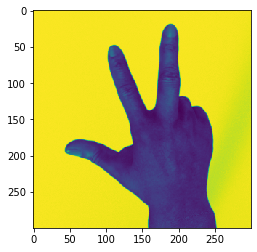

In [133]:
plt.imshow(x[0,:,:,2])

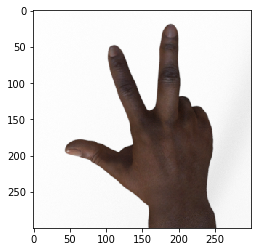

In [129]:
plt.imshow(x[0,:,:,:])

In [140]:
y.shape

TensorShape([32, 3])

In [141]:
y[0]

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 0., 1.], dtype=float32)>

,image,label
0,,2 (scissors)
1,,2 (scissors)
2,,0 (rock)
3,,1 (paper)
4,,0 (rock)
5,,1 (paper)
6,,2 (scissors)
7,,1 (paper)
8,,2 (scissors)
9,,2 (scissors)

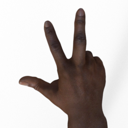
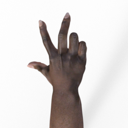
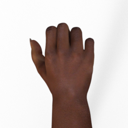
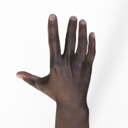
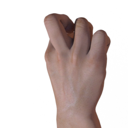
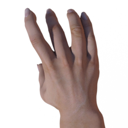
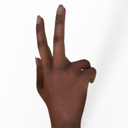
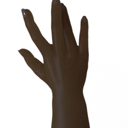
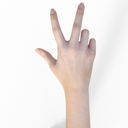
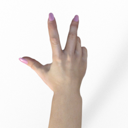

In [44]:
tfds.as_dataframe(data["train"].take(10), info)

# Exercise

### 1. Build a deep CNN model and train it for this binary classification task. Fit the model using the small dataset of 500 samples, *train_data*.

What accuracy can your model acheive on the training data?

In [88]:
# Your code here

In [145]:
model = tfk.Sequential()

#input_shape=(300,300,3), output unit size is 3 for rock-paper-scissors 

#Block 1
model.add(tfkl.Conv2D(filters = 20, kernel_size=(3,3), strides=(3,3), 
                      padding="valid", activation='relu', input_shape=(300, 300, 3))) #smooth stride; padding: handle edges;
model.add(tfkl.MaxPool2D(pool_size=2))
model.add(tfkl.Dropout(.2))

#Block 2
model.add(tfkl.Conv2D(filters = 16, kernel_size=2, strides=2, 
                      padding="valid", activation='relu')) #smooth stride; padding: handle edges;
model.add(tfkl.MaxPool2D(pool_size=2))
model.add(tfkl.Dropout(.2))

#Block 3
model.add(tfkl.Conv2D(filters = 8, kernel_size=2, strides=2, 
                      padding="valid", activation='relu')) #smooth stride; padding: handle edges;
model.add(tfkl.MaxPool2D(pool_size=2))
model.add(tfkl.Dropout(.2))

#Flatten
model.add(tfkl.GlobalMaxPool2D())
model.add(tfkl.Dense(3, activation='softmax'))

In [146]:
model.summary()
#parameters number is 560 in first layer, because kernal size is (3,3), input shape is (300,300,3), and bias=1, filter=20;
# so 560 = ((3*3*3)+1)*20, which is, (kernal_size * input_depth + bias)*kernal_number

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 100, 100, 20)      560       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 50, 50, 20)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 50, 50, 20)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 25, 25, 16)        1296      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 12, 12, 16)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 12, 12, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 6, 6, 8)          

In [161]:
model.compile(
    optimizer=tfk.optimizers.RMSprop(),
    loss=tfk.losses.CategoricalCrossentropy(),
    metrics=["acc"]
)

cbs = [tfk.callbacks.EarlyStopping(min_delta=0.01,patience=2)] # see Module4_keras_lab.ipynb

results = model.fit(train_data, batch_size=32, epochs=20,callbacks=cbs,verbose=1)

Epoch 1/20
78/79 [============================>.] - ETA: 0s - loss: 0.6871 - acc: 0.7079WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc


79/79 [==============================] - 4s 54ms/step - loss: 0.6861 - acc: 0.7087
Epoch 2/20
78/79 [============================>.] - ETA: 0s - loss: 0.6419 - acc: 0.7300WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc


79/79 [==============================] - 4s 54ms/step - loss: 0.6414 - acc: 0.7310
Epoch 3/20
78/79 [============================>.] - ETA: 0s - loss: 0.6351 - acc: 0.7320WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc


79/79 [==============================] - 4s 53ms/step - loss: 0.6348 - acc: 0.7317
Epoch 4/20
78/79 [============================>.] - ETA: 0s - loss: 0.6242 - acc: 0.7404WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc


79/79 [==============================] - 4s 55ms/step - loss: 0.6227 - acc: 0.7417
Epoch 5/20
78/79 [============================>.] - ETA: 0s - loss: 0.6019 - acc: 0.7464WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc


79/79 [==============================] - 4s 55ms/step - loss: 0.6020 - acc: 0.7472
Epoch 6/20
78/79 [============================>.] - ETA: 0s - loss: 0.6062 - acc: 0.7492WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc


79/79 [==============================] - 4s 54ms/step - loss: 0.6050 - acc: 0.7504
Epoch 7/20
79/79 [==============================] - ETA: 0s - loss: 0.5659 - acc: 0.7667WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc


79/79 [==============================] - 4s 54ms/step - loss: 0.5659 - acc: 0.7667
Epoch 8/20
79/79 [==============================] - ETA: 0s - loss: 0.5836 - acc: 0.7540WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc


79/79 [==============================] - 4s 54ms/step - loss: 0.5836 - acc: 0.7540
Epoch 9/20
78/79 [============================>.] - ETA: 0s - loss: 0.5846 - acc: 0.7692WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc


79/79 [==============================] - 4s 55ms/step - loss: 0.5840 - acc: 0.7694
Epoch 10/20
78/79 [============================>.] - ETA: 0s - loss: 0.5676 - acc: 0.7608WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc


79/79 [==============================] - 4s 54ms/step - loss: 0.5691 - acc: 0.7587
Epoch 11/20
79/79 [==============================] - ETA: 0s - loss: 0.5404 - acc: 0.7865WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc


79/79 [==============================] - 5s 58ms/step - loss: 0.5404 - acc: 0.7865
Epoch 12/20
78/79 [============================>.] - ETA: 0s - loss: 0.5506 - acc: 0.7800WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc


79/79 [==============================] - 4s 54ms/step - loss: 0.5510 - acc: 0.7794
Epoch 13/20
78/79 [============================>.] - ETA: 0s - loss: 0.5450 - acc: 0.7885WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc


79/79 [==============================] - 4s 54ms/step - loss: 0.5436 - acc: 0.7893
Epoch 14/20
78/79 [============================>.] - ETA: 0s - loss: 0.5274 - acc: 0.7800WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc


79/79 [==============================] - 4s 56ms/step - loss: 0.5268 - acc: 0.7798
Epoch 15/20
78/79 [============================>.] - ETA: 0s - loss: 0.5097 - acc: 0.8041WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc


79/79 [==============================] - 4s 57ms/step - loss: 0.5099 - acc: 0.8044
Epoch 16/20
78/79 [============================>.] - ETA: 0s - loss: 0.5140 - acc: 0.7853WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc


79/79 [==============================] - 4s 55ms/step - loss: 0.5137 - acc: 0.7849
Epoch 17/20
79/79 [==============================] - ETA: 0s - loss: 0.5046 - acc: 0.7964WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc


79/79 [==============================] - 4s 55ms/step - loss: 0.5046 - acc: 0.7964
Epoch 18/20
78/79 [============================>.] - ETA: 0s - loss: 0.4934 - acc: 0.8125WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc


79/79 [==============================] - 4s 57ms/step - loss: 0.4916 - acc: 0.8127
Epoch 19/20
78/79 [============================>.] - ETA: 0s - loss: 0.4873 - acc: 0.8013WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc


79/79 [==============================] - 4s 55ms/step - loss: 0.4867 - acc: 0.8020
Epoch 20/20
78/79 [============================>.] - ETA: 0s - loss: 0.5028 - acc: 0.7989WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc


79/79 [==============================] - 4s 55ms/step - loss: 0.5016 - acc: 0.7992


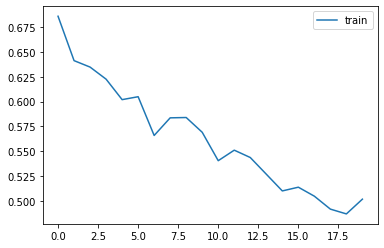

In [162]:
plt.plot(results.history["loss"])
#plt.plot(results.history["val_loss"]) #without val_loss
#plt.legend(labels=["train", "val"])
plt.legend(labels=["train"])

### training data accuracy

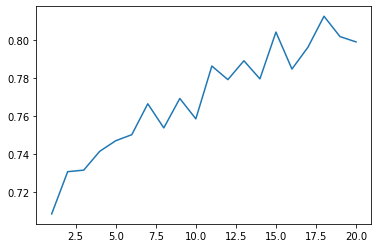

In [165]:
acc = results.history["acc"]
epochs = range(1,len(acc) + 1)
plt.plot(epochs,acc)

### 2. Now use transfer learning by incorporating the pretrained VGG16 model.

In [166]:
from tensorflow.keras.applications import VGG16

In [167]:
conv_base = VGG16(weights="imagenet",include_top=False,input_shape=(300,300,3))

58892288/58889256 [==============================] - 2s 0us/step


Build a Sequential model, using our VGG16 base. Make sure the freeze the weights of the convolutional backbone, but leave the remainder of the network weights as learnable. Fit this model and compare the overall accuracy as well as the loss curves (efficiency).


In [168]:
# Your code here

In [169]:
conv_base